In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib
from pathlib import Path
from collections import namedtuple, defaultdict
import json
import itertools
from sklearn.preprocessing import normalize

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
data_dir = Path('distributed-debugging.17.10.2023.interpreted_full')

device_dirs = [dev_dir for dev_dir in data_dir.iterdir() if dev_dir.is_dir()]
rt_names = set([d.name for d in device_dirs])
files = [file for dir in device_dirs for file in dir.iterdir()]


In [334]:
dd = {}
for dev in device_dirs:
    for file in dev.iterdir():
        rt = dev.name
        bench, density = file.name.split('.')[:2]
        if bench not in dd:
            dd[bench] = {}
        if rt not in dd[bench]:
            dd[bench][rt] = {}
        if density not in dd[bench][rt]:
            dd[bench][rt][density] = []
        with open(file) as f:
            dd[bench][rt][density].append(json.load(f))
            
def parse_files(profs):
    num_prof = len(profs)
    time = np.mean([x["cpu_time"] for x in profs], dtype=np.int64)
    violations = np.array([[v["i1"], v["i2"]] for x in profs for v in x["violations"]]).reshape(-1,2).astype(np.uint64)
    violation_lens = [len(x['violations']) for x in profs]
    non_libc_violations = violations[((violations[:,0] < 900).nonzero())[0]] if violations.size else violations
    uv, count = np.unique(np.sort(non_libc_violations), axis=0, return_counts=True)
    return { 
             "runs": num_prof,
             "cpu_time": time, 
             "total_violations": np.sum(count),
             "median_violations": np.median(violation_lens).astype(np.uint64),
             "unique_violations": uv,
             "unique_violation_count": count
        }

def __parse(tdict):
    for k, v in tdict.items():
        if isinstance(v, dict):
            __parse(v)
        else:
            tdict[k] = parse_files(v)
        
__parse(dd)
data_dict = dd
        

In [335]:
print(data_dict['comp-unopt-bug'])

{'hc-19': {'45': {'runs': 500, 'cpu_time': 471161, 'total_violations': 0, 'median_violations': 0, 'unique_violations': array([], shape=(0, 2), dtype=uint64), 'unique_violation_count': array([], dtype=int64)}, '60': {'runs': 500, 'cpu_time': 620228, 'total_violations': 2, 'median_violations': 0, 'unique_violations': array([[ 464, 1064]], dtype=uint64), 'unique_violation_count': array([2])}, '40': {'runs': 500, 'cpu_time': 433780, 'total_violations': 0, 'median_violations': 0, 'unique_violations': array([], shape=(0, 2), dtype=uint64), 'unique_violation_count': array([], dtype=int64)}, '80': {'runs': 500, 'cpu_time': 801811, 'total_violations': 3, 'median_violations': 0, 'unique_violations': array([[ 464, 1064]], dtype=uint64), 'unique_violation_count': array([3])}, '35': {'runs': 500, 'cpu_time': 382416, 'total_violations': 0, 'median_violations': 0, 'unique_violations': array([], shape=(0, 2), dtype=uint64), 'unique_violation_count': array([], dtype=int64)}, '55': {'runs': 500, 'cpu_ti

### Assumption: Statistical independence between bugs found

In [374]:
# hc-33, hc-34, hc-35: skylake/tigerlake
# hc-27, hc-25: aarch64
# hc-13, hc-11: other AMD stuff
test_devs = {
    "lakes": ['hc-34', 'hc-33', 'hc-35'],
    "arms": ['hc-27', 'hc-25'],
    "zens": ['hc-13', 'hc-11']
}
setups = {
    #"single1": test_devs["lakes"][:1], 
    #"single2": test_devs["lakes"][1:2], 
    #"single3": test_devs["lakes"][2:3], 
    #"single4": test_devs["arms"][:1], 
    #"single5": test_devs["zens"][:1], 
    "no-hg": test_devs["lakes"], 
    #"dev-hg": test_devs["lakes"][:2] + test_devs["zens"][:1],
    #"arch-hg": test_devs["lakes"][:2] + test_devs["arms"][:1],
    "full-hg": test_devs["lakes"][:1] + test_devs["arms"][:1] + test_devs["zens"][:1]
}

setup_color_list = ['#e0adad', '#ebe9bc', '#d6ebbc', '#429642']
setup_colors = {x: setup_color_list[i] for i,x in enumerate(setups)}

valid_benches = ['thread_lock', 'lfq', 'loop-antidep', 'comp-unopt-bug']

def __get_profile():
    tdict = {}
    for setup_name, setup_devs in setups.items():
        tdict[setup_name] = {bench: {d: data_dict[bench][d] for d in setup_devs} for bench in valid_benches}
    return tdict
    


## Average count profile

In [375]:
bug_count_profile = {}
# threadlock, lfq, input-dep    
    
def __pp(tdict):
    min_val = 500
    min_trace = []
    min_trace_key = None
    for k, v in tdict.items():
        if isinstance(v, dict):
            x, min_trace = __pp(v)
            if x < min_val:
                min_trace_key = k
                min_val = x
        else:
            if k == 'runs':
                min_val = v if v < min_val else min_val
                min_trace_key = 'runs'
                
    min_trace.append(min_trace_key)
    return min_val, min_trace
                

bug_count_profile = __get_profile()
print(f"Min runs: {__pp(bug_count_profile)}")

Min runs: (500, ['runs', None, None, None, None])


In [376]:
def merge_average_counts(s, tdict):
    merge_dict = {}
    for dev_dict in tdict:
        for k, v in dev_dict.items():
            if k not in merge_dict:
                merge_dict[k] = { "runs": 0, "vs": 0}
            merge_dict[k]["runs"] += v["runs"]
            merge_dict[k]["vs"] += v["total_violations"]
        
    return {k: v['vs']/v['runs'] for k, v in merge_dict.items()}

for setup_name, setup_res in bug_count_profile.items():
    for bench, bench_res in setup_res.items():
        bug_count_profile[setup_name][bench] = merge_average_counts(setup_name, bench_res.values())

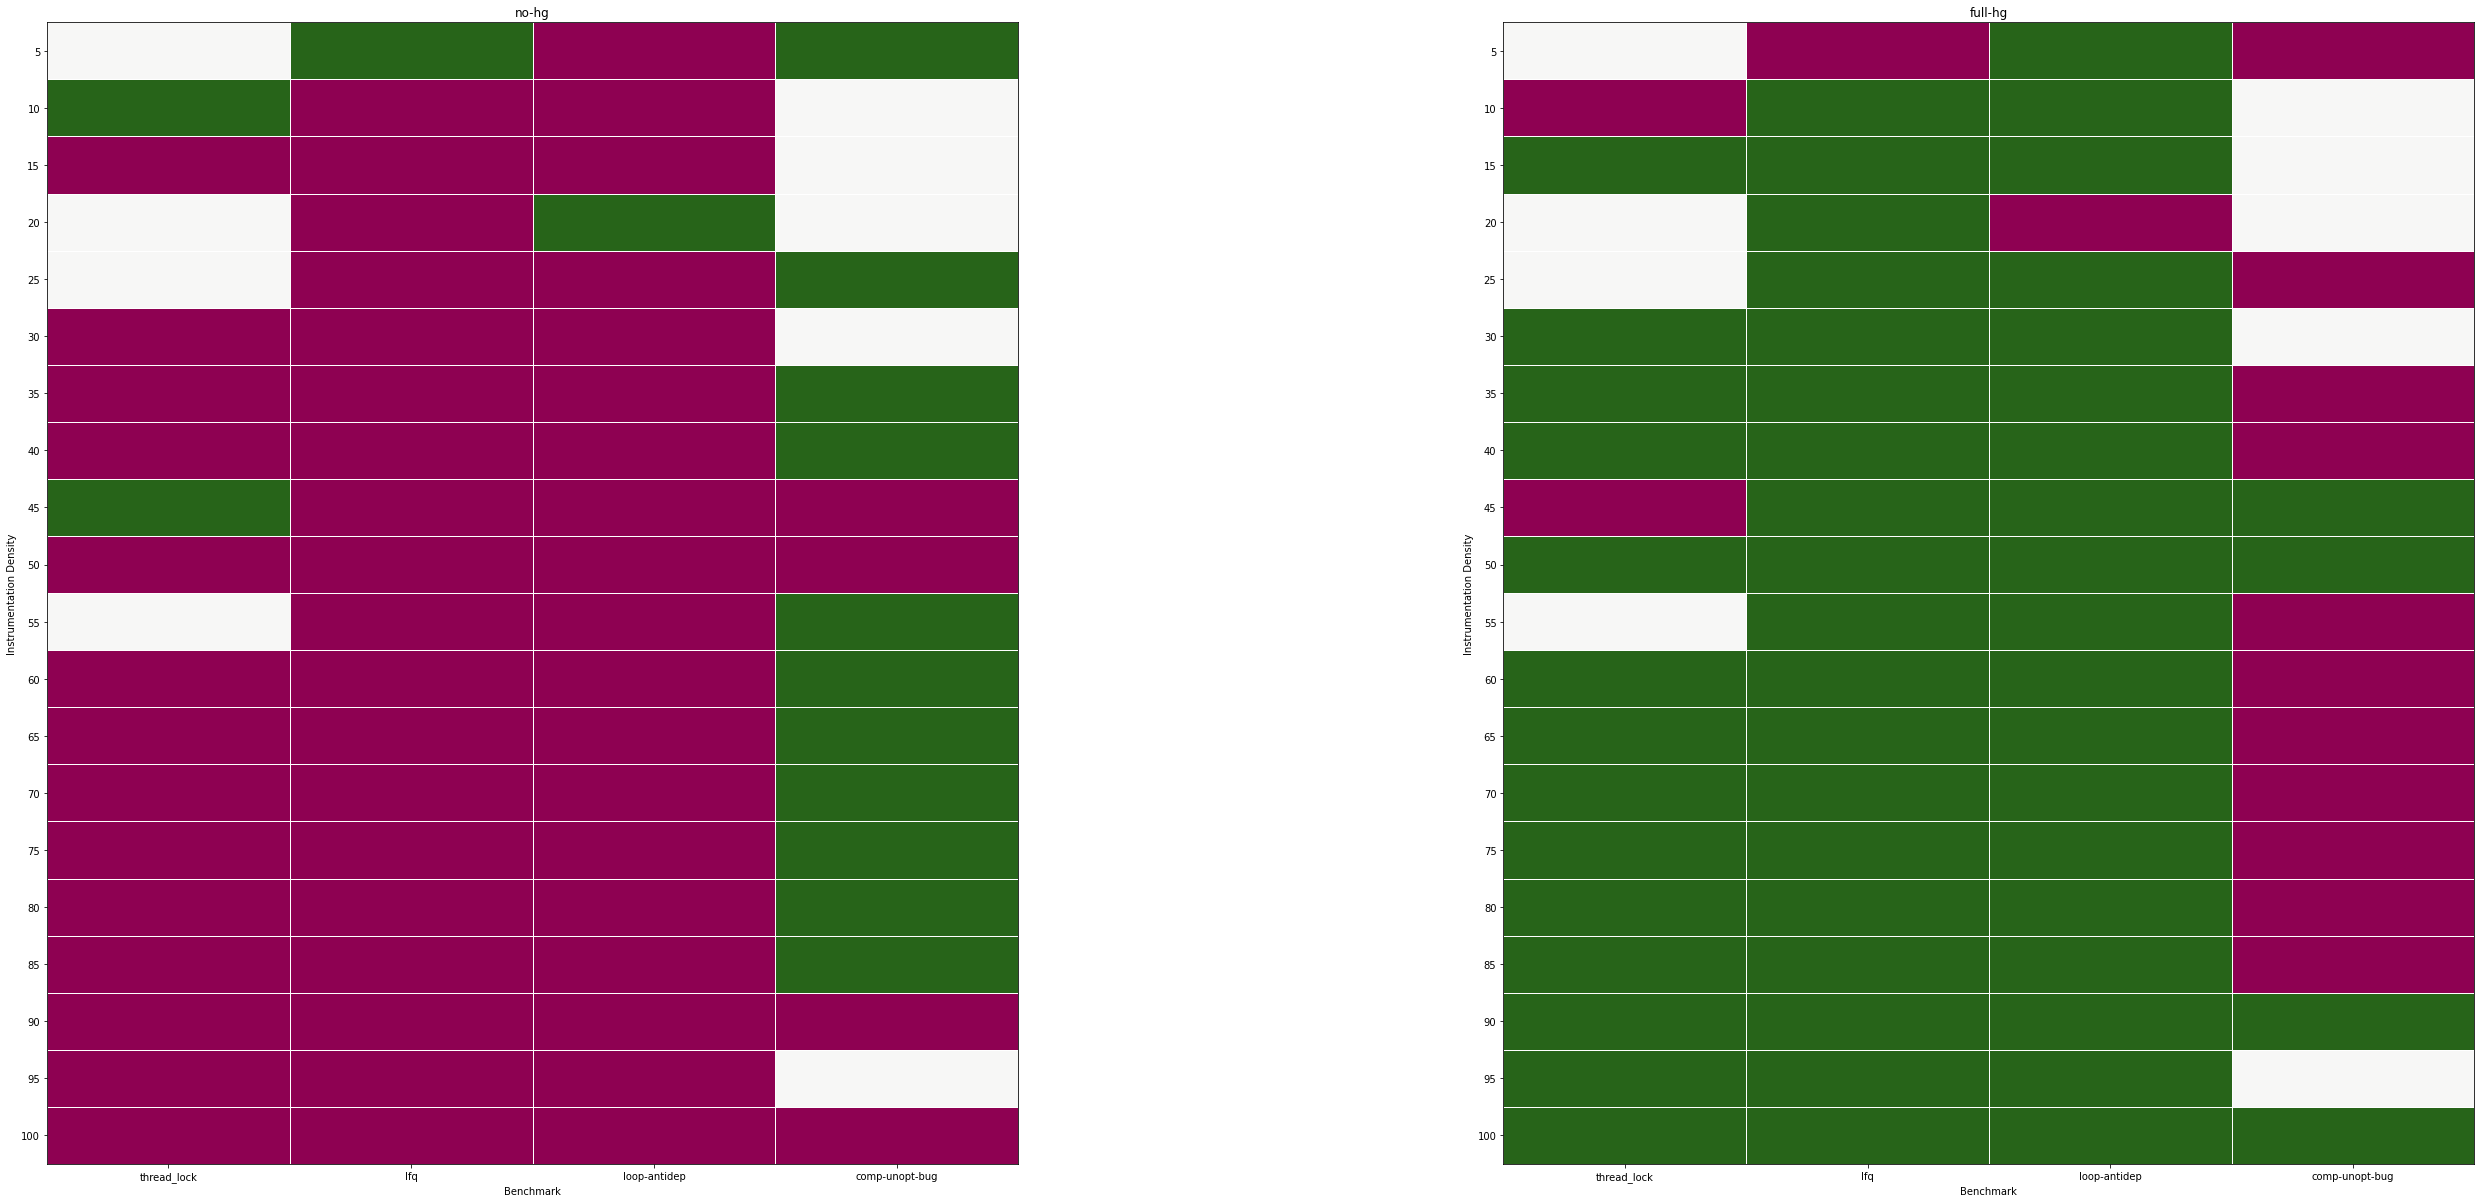

In [377]:
benches = bug_count_profile['no-hg'].keys()
setup_names = list(setups.keys())
densities = np.arange(0, 105, 5)

num_bench = len(benches)
num_setups = len(setup_names)

mvc = np.array([[[bug_count_profile[s][b][str(i)] for i in densities] for b in benches] for s in setup_names])
# mvc = [setups x benchs x densities]

color_res = np.zeros(mvc.shape)
epsilon = 1e-10

for index, _ in np.ndenumerate(mvc[0,:,:]):
    vals = np.array([mvc[x,index[0],index[1]] for x in range(num_setups)])
    std_dev = np.std(vals)
    mean = np.mean(vals)
    normer = matplotlib.colors.Normalize(vmin=-std_dev-epsilon, vmax=std_dev+epsilon)
    for x in range(num_setups):
        color_res[x, index[0], index[1]] = normer(mvc[x, index[0], index[1]] - mean)

        
setup_plot_idx = [i for i, x in enumerate(setups.keys()) if not x.startswith("single")]
num_plot_setups = len(setup_plot_idx)

cmap = matplotlib.colormaps['PiYG']
fig, axs = plt.subplots(1, num_plot_setups, figsize=(29*1.5, 14*1.5), squeeze=False)
plt.subplots_adjust(wspace=0.5)
for i in range(num_plot_setups):
    idx = setup_plot_idx[i]
    axs[0][i].pcolormesh(list(benches), densities[:0:-1], cmap(color_res[idx,:,1:].T), edgecolor='w')
    axs[0][i].set_yticks(ticks=densities[1:], labels=densities[:0:-1])
    axs[0][i].set_xlabel('Benchmark')
    axs[0][i].set_ylabel('Instrumentation Density')
    axs[0][i].set_title(setup_names[idx])


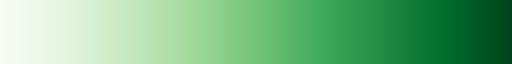

In [265]:
cmap = sns.color_palette('Greens', as_cmap=True)
#cmap(np.array([0, 0.2, 0, 0.5, 0.99]))
cmap

In [ ]:
fig.savefig('figs/average_bugs.jpg', dpi=300)

## Per-violation profile

In [378]:
violation_profile = {}

cdensities = densities[1:]

def uv_arr(tdict):
    fields = ['unique_violations', 'unique_violation_count']
    return {x: [tdict[str(i)][x] for i in cdensities] for x in fields}

def stack_list(vec):
    return np.concatenate((*vec,), axis=0)

def get_unique_bench_violations(tdict):
    all_violations_bench = stack_list( [stack_list([stack_list(dev_vec['unique_violations']) for dev_vec in setup_data_vec]) 
                                for setup_data_vec in tdict.values()] )
    return np.unique(all_violations_bench, axis=0)

def construct_setup_matrix(setup_arr, hasher):
    matrix = np.zeros((len(hasher), len(cdensities)), dtype=np.uint64)
    #violations_setup = stack_list([stack_list(dev_vec['unique_violations']) for dev_vec in setup_arr])
    vs = [np.concatenate(x) for x in zip(*[dev_vec['unique_violations'] for dev_vec in setup_arr])]
    ct = [np.concatenate(x) for x in zip(*[dev_vec['unique_violation_count'] for dev_vec in setup_arr])]
    for i, v in enumerate(vs):
        uvs, inv = np.unique(v, axis=0, return_inverse=True)
        for j, x in enumerate(inv):
            matrix[hasher[tuple(uvs[x])], i] += ct[i][j]
        
    return matrix
            
global_unique_violations = {}
for bench in valid_benches:
    violation_profile[bench] = {sname: [uv_arr(data_dict[bench][d]) for d in sdevs] for sname, sdevs in setups.items()}
    print(f"Construct {bench}")
    #if bench == 'thread_lock':
    #    print(violation_profile[bench])
    global_unique_violations[bench] = get_unique_bench_violations(violation_profile[bench])
    
global_uvhash = {bench: {tuple(x): i for i, x in enumerate(vlist)} for bench, vlist in global_unique_violations.items()}

setup_unique_violations = {}
for bench in global_unique_violations:
    setup_unique_violations[bench] = { setup: construct_setup_matrix(setup_data, global_uvhash[bench]) for setup, setup_data in violation_profile[bench].items() }

print(global_uvhash)
#violation_profile
setup_unique_violations

Construct thread_lock
Construct lfq
Construct loop-antidep
Construct comp-unopt-bug
{'thread_lock': {(4, 18): 0}, 'lfq': {(4, 8): 0, (7, 21): 1, (7, 50): 2, (8, 15): 3, (10, 31): 4, (21, 39): 5, (22, 23): 6, (22, 32): 7, (22, 34): 8, (23, 23): 9, (23, 29): 10, (23, 30): 11, (23, 32): 12, (23, 34): 13, (24, 25): 14, (24, 33): 15, (25, 25): 16, (25, 33): 17, (26, 27): 18, (26, 35): 19, (36, 40): 20, (39, 50): 21, (40, 47): 22, (42, 60): 23, (51, 52): 24, (51, 61): 25, (51, 63): 26, (52, 52): 27, (52, 58): 28, (52, 59): 29, (52, 61): 30, (52, 63): 31, (53, 54): 32, (53, 62): 33, (54, 54): 34, (54, 62): 35, (55, 56): 36, (55, 64): 37}, 'loop-antidep': {(5, 6): 0}, 'comp-unopt-bug': {(464, 1064): 0}}


{'thread_lock': {'no-hg': array([[0, 2, 0, 0, 3, 0, 2, 3, 4, 2, 3, 1, 6, 2, 0, 0, 0, 0, 1, 0]],
        dtype=uint64),
  'full-hg': array([[ 0,  0,  2,  0,  3,  2,  4,  4,  1,  3,  3,  6, 13,  5,  5,  6,
           9,  4, 10,  4]], dtype=uint64)},
 'lfq': {'no-hg': array([[   4,   10,   32,   49,   93,  140,  189,  227,  301,  378,  444,
           540,  636,  727,  842,  954, 1097, 1210, 1346, 1500],
         [   7,   14,   27,   53,   72,  105,  133,  158,  210,  257,  313,
           340,  370,  435,  504,  598,  674,  723,  694,  692],
         [   2,    2,   10,   11,   17,   34,   35,   55,   74,   90,   90,
            92,  120,  143,  150,  229,  302,  301,  331,   91],
         [   4,   17,   16,   30,   49,   63,   82,   75,  109,  130,  142,
           143,  160,  178,  210,  339,  402,  371,  282,   36],
         [   0,    0,    1,    1,    0,    0,    0,    1,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0],
         [   0,    6,    4,    

Bench: thread_lock
5-20% effectiveness (no-hg): 1.0
5-20% effectiveness (full-hg): 1.0
Bench: lfq
5-20% effectiveness (no-hg): 0.9142857142857143
5-20% effectiveness (full-hg): 0.8888888888888888
Bench: loop-antidep
5-20% effectiveness (no-hg): 1.0
5-20% effectiveness (full-hg): 1.0
Bench: comp-unopt-bug
5-20% effectiveness (no-hg): 1.0
5-20% effectiveness (full-hg): 0.0


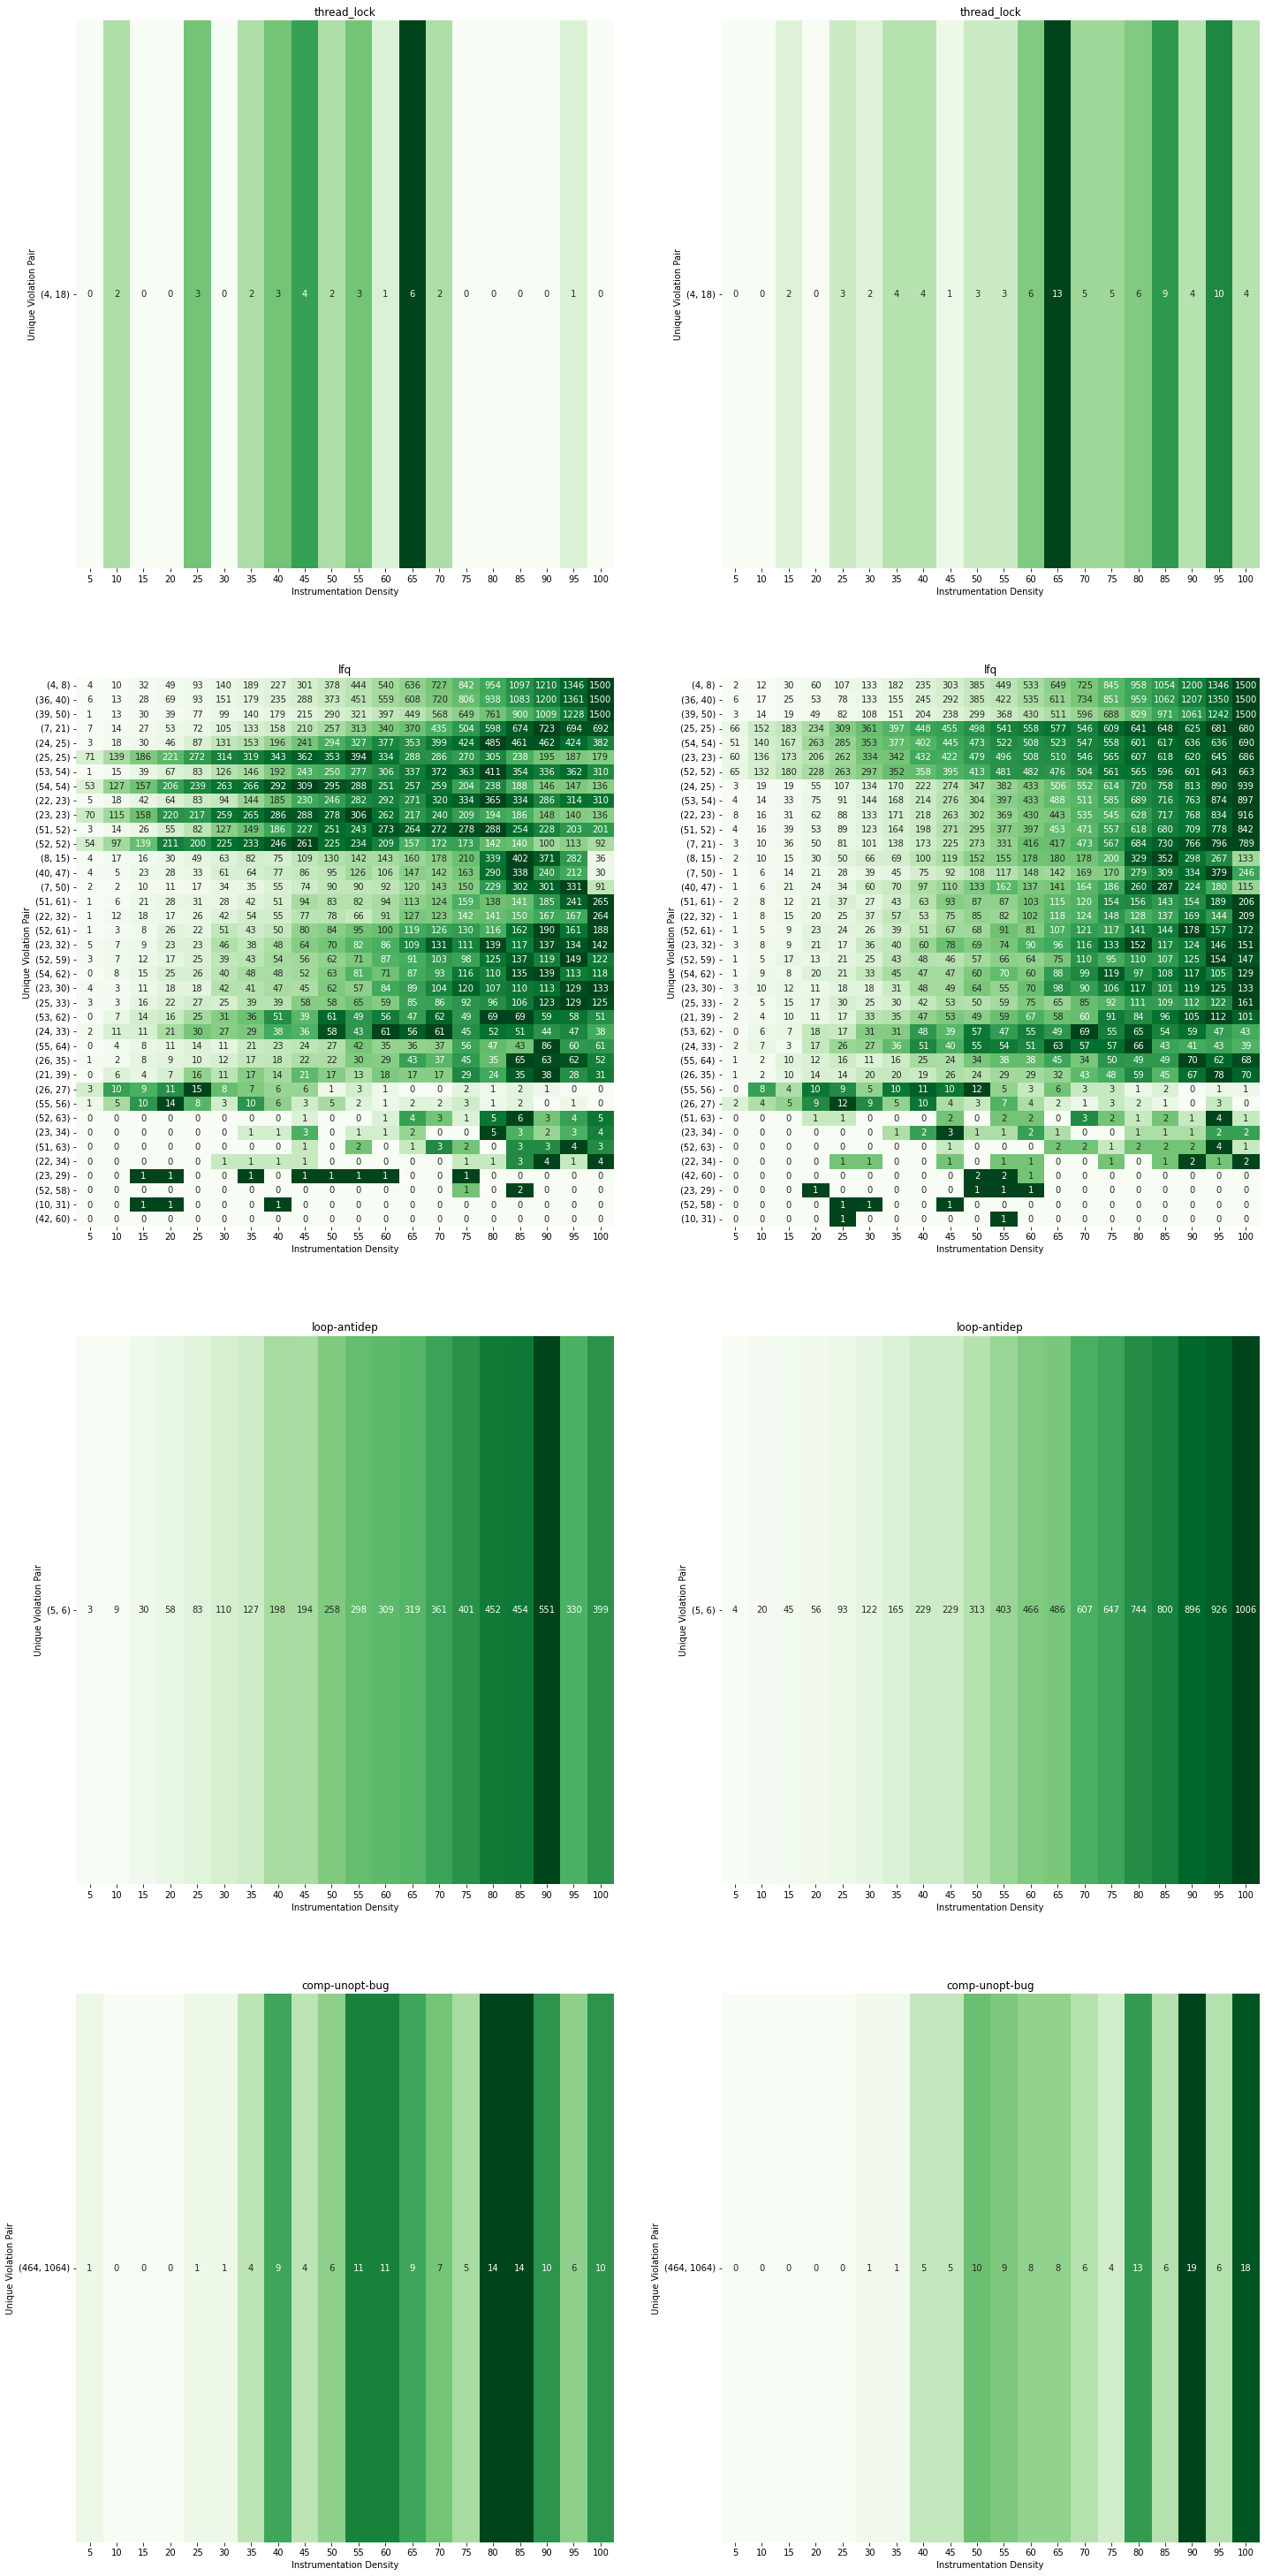

In [379]:
num_bench = len(setup_unique_violations)
fig, axs = plt.subplots(num_bench, 2, figsize=(16*1.5, 35*1.5), squeeze=False)
plt.subplots_adjust(hspace=0.2)

cmap = matplotlib.colormaps['Greens']
i = 0
for bench, bench_data in setup_unique_violations.items():
    print(f"Bench: {bench}")
    j = 0
    for setup, setup_data in bench_data.items():
        matrix = setup_data #bench_data['full-hg']
        violation_total_counts = np.sum(matrix, axis=1)
        sorted_vidxs = np.argsort(violation_total_counts)[::-1]

        max_per_violation = np.max(matrix, axis=1)

        color_matrix = np.zeros(matrix.shape)
        for x, maxv in enumerate(max_per_violation):
            normer = matplotlib.colors.Normalize(vmin=0, vmax=maxv)
            color_matrix[x,:] = normer(matrix[x,:])

        violation_keys = list(global_uvhash[bench].keys())
        sorted_violation_keys = [violation_keys[x] for x in sorted_vidxs]
        
        # Results
        violations_per_density = np.count_nonzero(matrix, axis=0)
        max_violations_encountered = np.max(violations_per_density)
        print(f"5-20% effectiveness ({setup}): {np.max(violations_per_density[:4]) / max_violations_encountered}")
        s = sns.heatmap(color_matrix[sorted_vidxs,:], cmap='Greens',  
                        ax=axs[i][j], 
                        cbar=False,
                        annot=matrix[sorted_vidxs,:], fmt='.4g',
                        yticklabels=sorted_violation_keys, 
                        xticklabels=cdensities)
        s.set(xlabel='Instrumentation Density', ylabel='Unique Violation Pair', title=bench)
        s.set_yticklabels(labels=sorted_violation_keys, rotation=0)
        j += 1
    i += 1
    

In [289]:
fig.savefig('figs/per_violation_bugs.jpg', dpi=300)

## Execution Time Profile

In [373]:
data_dict

{'loop-antidep': {'hc-19': {'50': {'runs': 500,
    'cpu_time': 2680103,
    'total_violations': 65,
    'median_violations': 0,
    'unique_violations': array([[5, 6]], dtype=uint64),
    'unique_violation_count': array([65])},
   '55': {'runs': 500,
    'cpu_time': 3063250,
    'total_violations': 86,
    'median_violations': 0,
    'unique_violations': array([[5, 6]], dtype=uint64),
    'unique_violation_count': array([86])},
   '70': {'runs': 500,
    'cpu_time': 3410986,
    'total_violations': 85,
    'median_violations': 0,
    'unique_violations': array([[5, 6]], dtype=uint64),
    'unique_violation_count': array([85])},
   '95': {'runs': 500,
    'cpu_time': 4177225,
    'total_violations': 49,
    'median_violations': 0,
    'unique_violations': array([[5, 6]], dtype=uint64),
    'unique_violation_count': array([49])},
   '60': {'runs': 500,
    'cpu_time': 3150785,
    'total_violations': 84,
    'median_violations': 0,
    'unique_violations': array([[5, 6]], dtype=uint64),

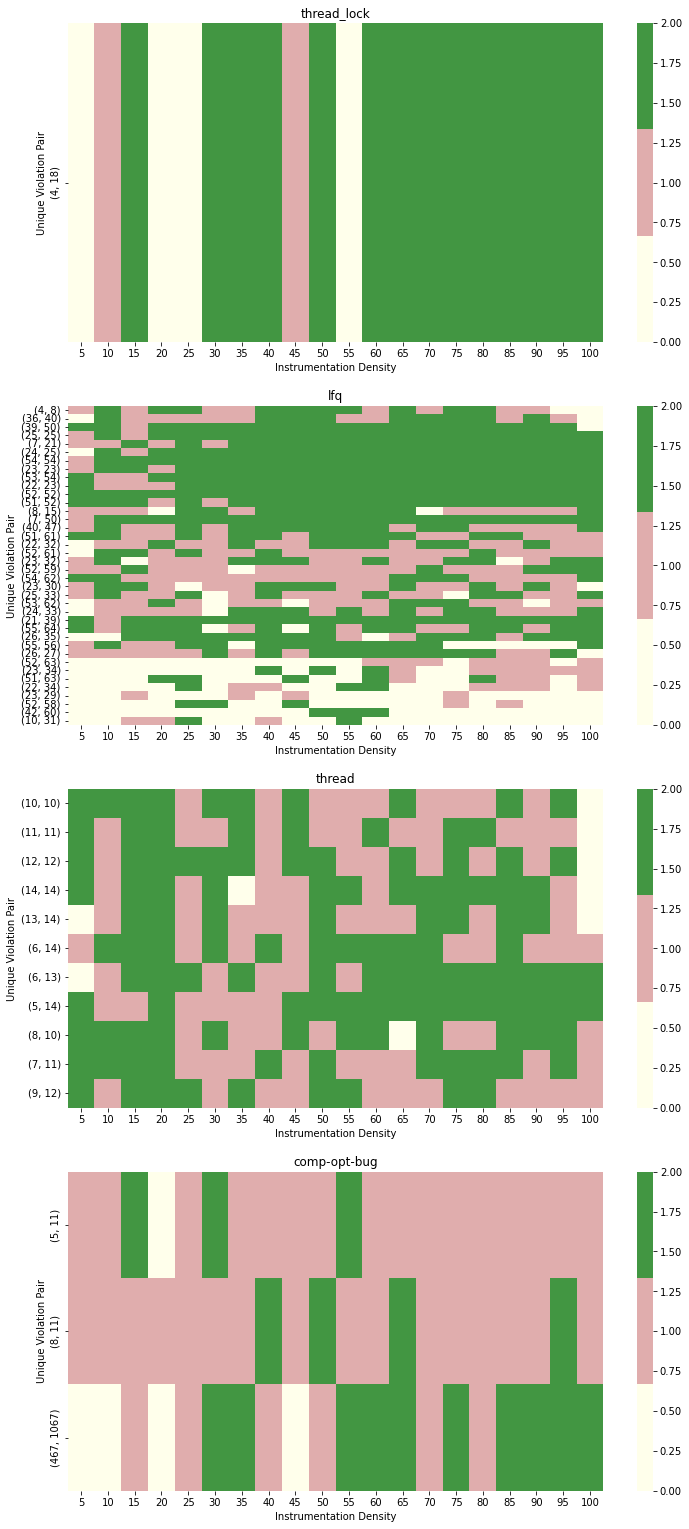

In [321]:
num_bench = len(setup_unique_violations)
fig, axs = plt.subplots(num_bench, 1, figsize=(8*1.5, 18*1.5), squeeze=False)
plt.subplots_adjust(hspace=0.2)

cmap = ListedColormap(['#ffffeb', '#e0adad', '#429642'])

i = 0
for bench, bench_data in setup_unique_violations.items():
    stacked_mat = np.stack((*bench_data.values(),))
    violation_total_counts = np.sum(stacked_mat, axis=(0,2))
    sorted_vidxs = np.argsort(violation_total_counts)[::-1]
    
    max_matrix = np.argmax(stacked_mat, axis=0)
    max_flip = np.argmax(np.flip(stacked_mat, axis=0), axis=0) 
    unequal_mask = (max_flip + max_matrix + 1 == len(bench_data)) * 1
    
    matrix_map = (max_matrix + 1) * unequal_mask
    
    violation_keys = list(global_uvhash[bench].keys())
    sorted_violation_keys = [violation_keys[x] for x in sorted_vidxs]
    s = sns.heatmap(matrix_map[sorted_vidxs,:], cmap=cmap,
                    ax=axs[i][0], 
                    cbar=True,
                    yticklabels=sorted_violation_keys, 
                    xticklabels=cdensities)
    s.set(xlabel='Instrumentation Density', ylabel='Unique Violation Pair', title=bench)
    i += 1
    